# Рекомендация тарифов

Нужно построить модель для задачи классификации, которая выберет клиенту подходящий тариф для перехода. Предобработка данных уже сделана ранее. Постройте модель с максимально большим значением *accuracy* (довести долю правильных ответов по крайней мере до 0.75).

## Загрузка данных

Импортируем используемые библиотеки и классы:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import time
from contextlib import contextmanager
from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

Прочитаем данные из файла:

In [2]:
data = pd.read_csv("/datasets/users_behavior.csv")



<b>Описание данных</b><div class="paragraph">Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:</div><ul><li><em>сalls</em> — количество звонков,</li><li><em>minutes</em> — суммарная длительность звонков в минутах,</li><li><em>messages</em> — количество sms-сообщений,</li><li><em>mb_used</em> — израсходованный интернет-трафик в Мб,</li><li><em>is_ultra</em> — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).</li></ul>

Посмотрим на первые 20 строк из датасета:

In [3]:
data.head(20)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Посмотрим на технические характеристики данных с помощью функции `info()`:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Построим `pairplot` график для рассмотрения попарного отношения столбцов, а также распределения их значений:

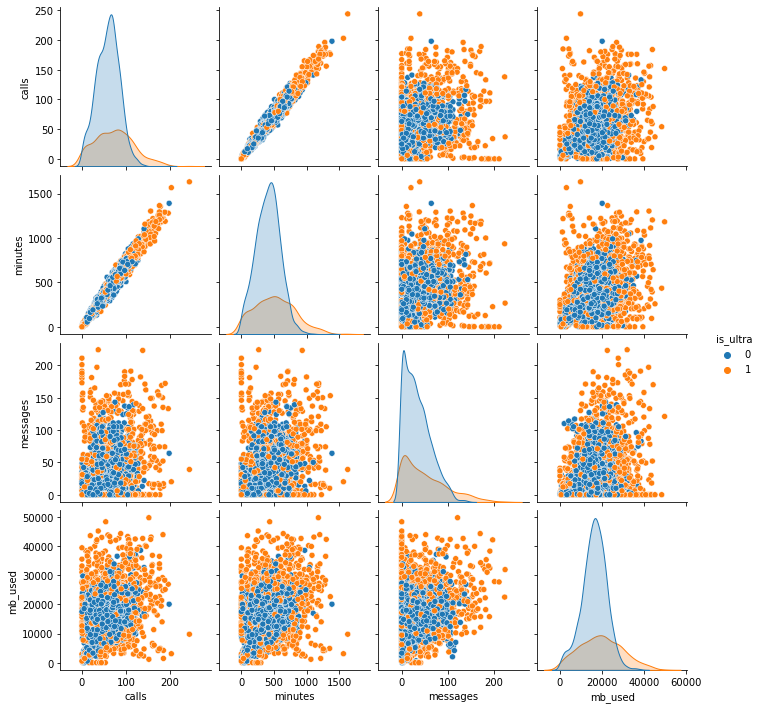

In [5]:
sns.pairplot(data=data, hue='is_ultra')
plt.show()

На графике видна практически линейная зависимость между calls и minutes. Подтвердим это также значением коэф. Пирсона близким к 1:

In [6]:
data['minutes'].corr(data['calls'])

0.9820832355742293

Далее столбец calls для предотвращения мультиколлиниеарности его со столбцом minutes в факторах(features) использовать не будем, оставим в features столбец minutes.

## Разбиение данных на выборки

Разобьем данные применив `train_test_split(...)` из библиотеки `sklearn.metrics` дважды: сначала выделив тестовую выборку (20% процентов от всех строк), затем из оставшихся данных выделим валидационную выборку (25% от оставшихся 80% от первоначального датасета в результате даст 20% строк исходных данных). Таким образом получаем выборки:
* обучающая - 60% строк
* валидационная - 20% строк
* тестовая - 20% строк

In [7]:
features = data.drop(["is_ultra", "calls"], axis=1)
target = data["is_ultra"]

features, features_test, target, target_test = train_test_split(
    features, target, test_size=0.2, random_state=6_10_22
)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=6_10_22
)
print("Total records count:", data.shape[0])
print("Train records count:", features_train.shape[0])
print("Test records count:", features_test.shape[0])
print("Validation records count:", features_valid.shape[0])

Total records count: 3214
Train records count: 1928
Test records count: 643
Validation records count: 643


## Обучение моделей

Исследуем следующие модели:
* DecisionTreeClassifier, изменяя гиперпараметр max_depth
* RandomForestClassifier, изменяя гиперпараметр max_depth и n_estimators
* LogisticRegression, изменяя гиперпараметр max_iter

In [8]:
# aux function to write different data as collection to array to be converted to DataFrame;
def add_model_record(results_array, **kwargs):
    results_array.append(kwargs)

### Модель LogisticRegression

Рассмотрим зависимость модели `LogisticRegression` от гиперпараметра `max_iter`, а также рассмотрим различные алгоритмы предлагаемые классом `LogisticRegression`:
* "liblinear", 
* "newton-cg", 
* "sag", 
* "saga", 
* "lbfgs"

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    accuracy_lgr_arr = []
    for iter in range(1, 80, 1):    
        for solver in ["liblinear", "newton-cg", "sag", "saga", "lbfgs"]:
            model_lgr = LogisticRegression(
                random_state=6_10_22, solver=solver, max_iter=iter
            )
            start_time = time.time()
            model_lgr.fit(features_train, target_train)
            seconds_fit_runs = time.time() - start_time

            add_model_record(
                accuracy_lgr_arr,
                model="LogisticRegression",
                # model_var=model_lgr,
                solver=solver,
                max_iter=iter,
                score_on_train=accuracy_score(
                    model_lgr.predict(features_train), target_train
                ),
                score_on_valid=accuracy_score(
                    model_lgr.predict(features_valid), target_valid
                ),
                seconds_fit_runs=seconds_fit_runs,
            )
    accuracy_lgr = pd.DataFrame(accuracy_lgr_arr)

Построим графики зависимости качества (accuracy) модели `LogisticRegression` от  параметра `max_iter` для различных алгоритмов:

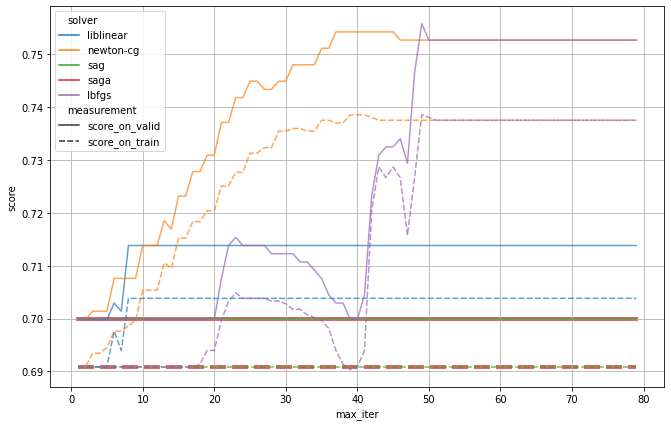

In [10]:
accuracy_lgr_melted = accuracy_lgr[
    ["solver", "max_iter", "score_on_train", "score_on_valid"]
].melt(id_vars=["solver", "max_iter"], var_name="measurement", value_name="score")

plt.subplots(figsize=(11, 7))
plt.grid()
fig = sns.lineplot(
    data=accuracy_lgr_melted,
    x="max_iter",
    y="score",
    hue="solver",
    style="measurement",
    style_order=["score_on_valid", "score_on_train"],
    dashes=True,
    alpha=0.7,
)

# fixing the overlap of lines for 'saga' and 'sag' solvers
fig.lines[7].set_linewidth(4)
fig.lines[7].set_zorder(-2)
fig.lines[6].set_linewidth(4)
fig.lines[6].set_zorder(-2)
plt.show()

# # alternative approach to build the graph
# plt.subplots(figsize=(11, 20))

# ax = sns.lineplot(data=accuracy_lgr, x="max_iter", y="score_on_train", hue="solver")
# [x.set_linestyle(":") for x in ax.lines]

# plt.grid()
# sns.lineplot(
#     data=accuracy_lgr,
#     x="max_iter",
#     y="score_on_valid",
#     hue="solver",
#     markers=True,
#     markeredgecolor="w",
#     dashes=False,
# )
# plt.show()0.2,

Найдем максимальные значения accuracy:

In [11]:
print(
    "\nMaximum accuracy score for validation data:",
    accuracy_lgr["score_on_valid"].max(),
)

cm = sns.light_palette("orange", as_cmap=True)

print("\nModels with maximum accuracy score for validation data:")
display(
    accuracy_lgr[
        accuracy_lgr["score_on_valid"] > accuracy_lgr["score_on_valid"].max() * 0.997
    ].style.background_gradient(cmap=cm)
)


Maximum accuracy score for validation data: 0.7558320373250389

Models with maximum accuracy score for validation data:


,model,solver,max_iter,score_on_train,score_on_valid,seconds_fit_runs
181,LogisticRegression,newton-cg,37,0.737033,0.754277,0.068511
186,LogisticRegression,newton-cg,38,0.737033,0.754277,0.076455
191,LogisticRegression,newton-cg,39,0.738589,0.754277,0.069430
196,LogisticRegression,newton-cg,40,0.738589,0.754277,0.072104
201,LogisticRegression,newton-cg,41,0.738589,0.754277,0.070561
206,LogisticRegression,newton-cg,42,0.738071,0.754277,0.071146
211,LogisticRegression,newton-cg,43,0.737552,0.754277,0.083302
216,LogisticRegression,newton-cg,44,0.737552,0.754277,0.076570
221,LogisticRegression,newton-cg,45,0.737552,0.754277,0.078895
244,LogisticRegression,lbfgs,49,0.738589,0.755832,0.014470


<b>Вывод:</b> Видим, что для модели `LogisticRegression` максимальное значение accuracy по валидационной выборке `0.754277`, `0.755832` получается для алгоритмов `newton-cg` и `lbfgs` соответственно. Причем lbfgs обучается быстрее чем newton-cg примерно в 4 раза (seconds_fit_runs), а для достижения максимальной точности lbfgs требуется на 4-13 итераций (значение max_iter) больше чем для newton-cg. Кроме того, на графике видно, что если у алгоритма newton-cg значение accuracy практически постоянно растет с увеличением параметра max_iter до уровня "насыщения" , то у lbfgs наблюдатся сильные колебания в показаниях качества модели в диапазоне max_iter ~ [20-50] и потом она приходит к тому же уровню, что и newton-cg. Остальные алгоритмы получают на валидационной выборке более плохой результат для accuracy, ниже целевого 0.75.

### Модели DecisionTreeClassifier и RandomForestClassifier

Модели DecisionTreeClassifier и RandomForestClassifier исследуем вместе, чтобы посмотреть в сравнении их зависимость от гиперпараметра max_depth:

In [12]:
accuracy_dtc_arr = []
accuracy_rfc_arr = []
for depth in range(1, 21):
    model_dtc = DecisionTreeClassifier(random_state=6_10_22, max_depth=depth)
    start_time = time.time()
    model_dtc.fit(features_train, target_train)
    seconds_fit_runs = time.time() - start_time
    add_model_record(
        accuracy_dtc_arr,
        model="DecisionTreeClassifier",
        # model_var=model_dtc,
        depth=depth,
        score_on_train=accuracy_score(model_dtc.predict(features_train), target_train),
        score_on_valid=accuracy_score(model_dtc.predict(features_valid), target_valid),
        seconds_fit_runs=seconds_fit_runs,
    )
    for est in range(20, 1101, 20):
        model_rfc = RandomForestClassifier(
            random_state=6_10_22, max_depth=depth, n_estimators=est, n_jobs=-1
        )

        start_time = time.time()
        model_rfc.fit(features_train, target_train)
        seconds_fit_runs = time.time() - start_time

        add_model_record(
            accuracy_rfc_arr,
            model="RandomForestClassifier",
            depth=depth,
            n_estimators=est,
            score_on_train=accuracy_score(
                model_rfc.predict(features_train), target_train
            ),
            score_on_valid=accuracy_score(
                model_rfc.predict(features_valid), target_valid
            ),
            seconds_fit_runs=seconds_fit_runs,
        )

Запишем результаты моделей в датафрейм:

In [13]:
accuracy_dtc = pd.DataFrame(accuracy_dtc_arr)
accuracy_rfc = pd.DataFrame(accuracy_rfc_arr)

#### Модель DecisionTreeClassifier - результаты

In [14]:
print(
    "\nMaximum accuracy score for validation data:",
    accuracy_dtc["score_on_valid"].max(),
)

print("\n\nModels with maximum accuracy score for validation data:")
accuracy_dtc.style.background_gradient(cmap=cm)


Maximum accuracy score for validation data: 0.7838258164852255


Models with maximum accuracy score for validation data:


,model,depth,score_on_train,score_on_valid,seconds_fit_runs
0,DecisionTreeClassifier,1,0.746888,0.743390,0.017852
1,DecisionTreeClassifier,2,0.779046,0.766719,0.002914
2,DecisionTreeClassifier,3,0.797199,0.783826,0.003906
3,DecisionTreeClassifier,4,0.797718,0.783826,0.004204
4,DecisionTreeClassifier,5,0.818983,0.765163,0.003954
5,DecisionTreeClassifier,6,0.828320,0.771384,0.005292
6,DecisionTreeClassifier,7,0.842842,0.768274,0.004557
7,DecisionTreeClassifier,8,0.858402,0.749611,0.006963
8,DecisionTreeClassifier,9,0.875000,0.752722,0.005273
9,DecisionTreeClassifier,10,0.887448,0.751166,0.006195


<b>Вывод:</b> Видим, что для модели DecisionTreeClassifier максимальное значение accuracy по валидационной выборке `0.783826` получается для глубины дерева (`max_depth`), равной `3` и `4`.

#### Модель RandomForestClassifier - гиперпараметр числа деревьев

Прежде чем исследовать влияние гиперпараметра n_estimators на accuracy модели RandomForestClassifier, зафиксируем интересные (близкие к оптимальным по значению accuracy) нам значения гиперпараметра max_depth:

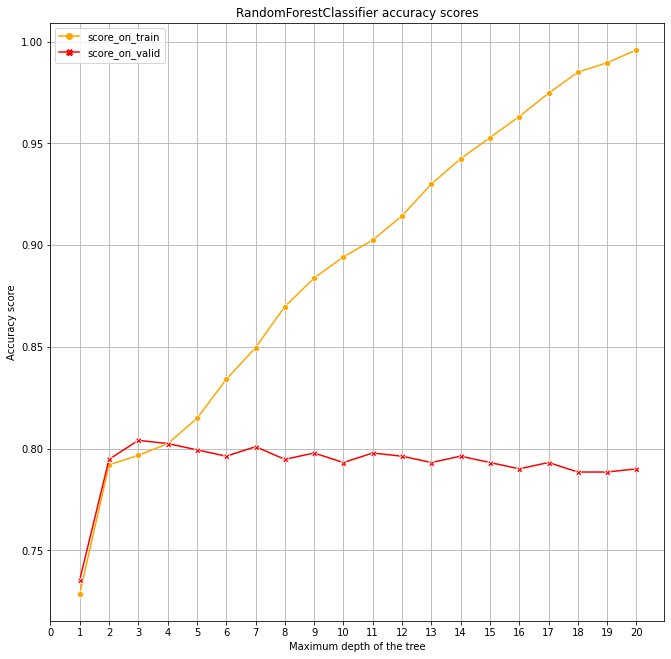

In [15]:
plt.subplots(figsize=(11, 11))

fig = sns.lineplot(
    data=accuracy_rfc.drop(
        ["n_estimators", "seconds_fit_runs"],
        axis=1,
    )
    .groupby("depth")
    .max(),
    palette=["orange", "r"],
    markers=True,
    markeredgecolor="w",
    dashes=False,
)

fig.set_title(
    "RandomForestClassifier accuracy scores"
)

fig.set_ylabel("Accuracy score")
fig.set_xlabel("Maximum depth of the tree")
fig.set_xticks(range(len(accuracy_dtc) + 1))
plt.grid()
plt.show()

Видим что диапазон значений глубины дерева с максимальной accuracy ~ 0.8, это max_depth = [2...12]

Так как RandomForestClassifier - самая требовательная к вычислительным ресурсам модель, посмотрим сколько минут потребовалось на обучение моделей:

In [16]:
minutes_timing = accuracy_rfc["seconds_fit_runs"].sum()/60
print(
    f"Сколько минут понадобилось на обучение моделей RandomForestClassifier с различными гиперпараметрами: {minutes_timing:.2f}"
)

Сколько минут понадобилось на обучение моделей RandomForestClassifier с различными гиперпараметрами: 21.76


Рассмотрим ниже зависимость качества модели RandomForestClassifier от гиперпараметра числа деревьев (n_estimators), для каждого числа деревьев на графике отобразим самый высокий результат среди всех получившихся значений accuracy с различными значениями глубины дерева (max_depth):

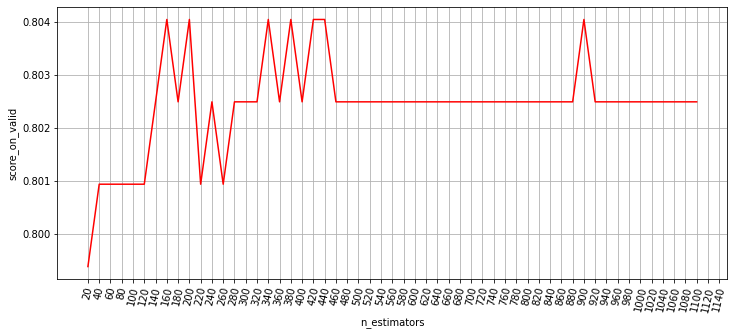

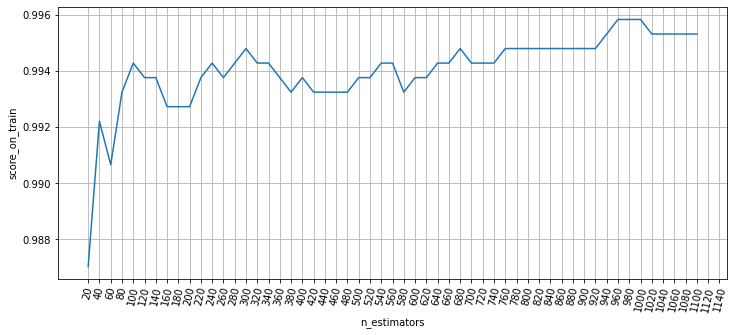

In [17]:
plt.subplots(figsize=(12, 5))
fig = sns.lineplot(
    data=accuracy_rfc.groupby("n_estimators").max().score_on_valid,
    color="r",
)

fig.xaxis.set_major_locator(tick.FixedLocator(range(20, 1401, 20)))
ticks_loc = fig.get_xticks().tolist()
fig.set_xticklabels(rotation=77, labels=ticks_loc)
plt.grid()
plt.show()

plt.subplots(figsize=(12, 5))
fig = sns.lineplot(data=accuracy_rfc.groupby("n_estimators").max().score_on_train)


fig.xaxis.set_major_locator(tick.FixedLocator(range(20, 1401, 20)))
ticks_loc = fig.get_xticks().tolist()
fig.set_xticklabels(rotation=77, labels=ticks_loc)
plt.grid()
plt.show()

Для валидационной выборки видны пики на уровне n_estimators=160 и n_estimators=340. Рассмотрим зависимость качества модели RandomForestClassifier от числа деревьев (n_estimators) ближе, в диапазонах [120..200] и [320..480] с шагом 1, чтобы найти максимальные значения качества модели (accuracy) в зависимости от этого параметра. Для этого обучим модели со значениями n_estimators из вышеуказанного диапазона, также варьируя параметр глубины дерева как мы делали это ранее (max_depth).

In [18]:
accuracy_rfc_arr_additional = []
for depth in range(2, 13):
    for est in range(120, 221, 1):
        model_rfc = RandomForestClassifier(
            random_state=6_10_22, max_depth=depth, n_estimators=est, n_jobs=-1
        )

        start_time = time.time()
        model_rfc.fit(features_train, target_train)
        seconds_fit_runs = time.time() - start_time

        add_model_record(
            accuracy_rfc_arr_additional,
            model="RandomForestClassifier",
            depth=depth,
            n_estimators=est,
            score_on_train=accuracy_score(
                model_rfc.predict(features_train), target_train
            ),
            score_on_valid=accuracy_score(
                model_rfc.predict(features_valid), target_valid
            ),
            seconds_fit_runs=seconds_fit_runs,
        )
    for est in range(320, 481, 1):
        model_rfc = RandomForestClassifier(
            random_state=6_10_22, max_depth=depth, n_estimators=est, n_jobs=-1
        )

        start_time = time.time()
        model_rfc.fit(features_train, target_train)
        seconds_fit_runs = time.time() - start_time

        add_model_record(
            accuracy_rfc_arr_additional,
            model="RandomForestClassifier",
            depth=depth,
            n_estimators=est,
            score_on_train=accuracy_score(
                model_rfc.predict(features_train), target_train
            ),
            score_on_valid=accuracy_score(
                model_rfc.predict(features_valid), target_valid
            ),
            seconds_fit_runs=seconds_fit_runs,
        )

Запишем данные в датафрейм:

In [19]:
accuracy_rfc_additional = pd.DataFrame(accuracy_rfc_arr_additional)

Опять же посмотрим сколько минут потребовалось на обучение дополнительных моделей:

In [20]:
minutes_timing = accuracy_rfc_additional["seconds_fit_runs"].sum()/60
print(
    f"Сколько минут понадобилось на обучение моделей RandomForestClassifier с различными гиперпараметрами: {minutes_timing:.2f}"
)

Сколько минут понадобилось на обучение моделей RandomForestClassifier с различными гиперпараметрами: 26.97


Построим графики для валидационной и тренировочной выборки с максимумами по max_depth:

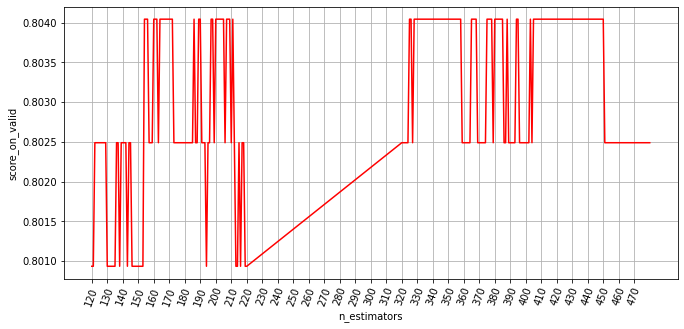

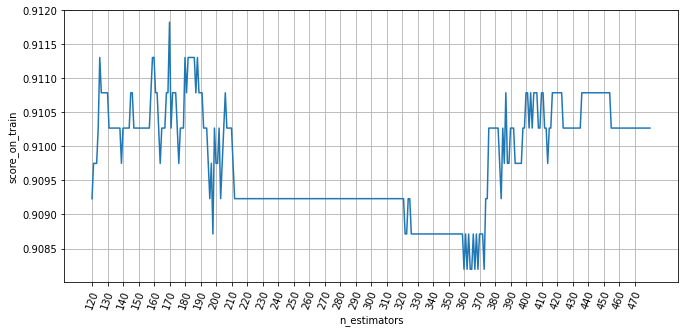

In [21]:
grouped_accuracy_rfc_additional = accuracy_rfc_additional.groupby("n_estimators")

ticks=tick.FixedLocator(range(120, 480, 10))
plt.subplots(figsize=(11, 5))
fig = sns.lineplot(data=grouped_accuracy_rfc_additional.max().score_on_valid, color="r")
fig.xaxis.set_major_locator(ticks)
ticks_loc = fig.get_xticks().tolist()
fig.set_xticklabels(rotation=70, labels=ticks_loc)
plt.grid()
plt.show()

plt.subplots(figsize=(11, 5))
fig = sns.lineplot(data=grouped_accuracy_rfc_additional.max().score_on_train)
fig.xaxis.set_major_locator(ticks)
ticks_loc = fig.get_xticks().tolist()
fig.set_xticklabels(rotation=70, labels=ticks_loc)
plt.grid()
plt.show()

Найдем максимальное значение accuracy для валидационной выборки и соответсвующие ей гиперпараметры:

In [22]:
print(
    "\nMaximum accuracy score for validation data:",
    accuracy_rfc_additional["score_on_valid"].max(),
)

cm = sns.light_palette("orange", as_cmap=True)
print("\n\nModels with n_estimators=325 to see difference for various max_depth:")
display(
    accuracy_rfc_additional[
        accuracy_rfc_additional["n_estimators"] == 325
    ].style.background_gradient(cmap=cm)
)

print("\n\nModels with maximum accuracy score for validation data:")
accuracy_rfc_additional[
    accuracy_rfc_additional["score_on_valid"]
    == accuracy_rfc_additional["score_on_valid"].max()
].style.background_gradient(cmap=cm)


Maximum accuracy score for validation data: 0.8040435458786936


Models with n_estimators=325 to see difference for various max_depth:


,model,depth,n_estimators,score_on_train,score_on_valid,seconds_fit_runs
106,RandomForestClassifier,2,325,0.788382,0.793157,0.449472
368,RandomForestClassifier,3,325,0.795643,0.804044,0.581923
630,RandomForestClassifier,4,325,0.802386,0.802488,0.477755
892,RandomForestClassifier,5,325,0.813797,0.797823,0.505666
1154,RandomForestClassifier,6,325,0.830913,0.788491,0.555021
1416,RandomForestClassifier,7,325,0.846473,0.797823,0.587765
1678,RandomForestClassifier,8,325,0.868776,0.791602,0.610601
1940,RandomForestClassifier,9,325,0.881743,0.793157,0.668183
2202,RandomForestClassifier,10,325,0.890041,0.786936,0.661922
2464,RandomForestClassifier,11,325,0.896784,0.791602,0.638999




Models with maximum accuracy score for validation data:


,model,depth,n_estimators,score_on_train,score_on_valid,seconds_fit_runs
296,RandomForestClassifier,3,154,0.794606,0.804044,0.216170
297,RandomForestClassifier,3,155,0.794087,0.804044,0.230042
298,RandomForestClassifier,3,156,0.794606,0.804044,0.227685
302,RandomForestClassifier,3,160,0.794087,0.804044,0.216588
303,RandomForestClassifier,3,161,0.794087,0.804044,0.231251
304,RandomForestClassifier,3,162,0.794606,0.804044,0.235077
306,RandomForestClassifier,3,164,0.794087,0.804044,0.233826
307,RandomForestClassifier,3,165,0.794606,0.804044,0.233473
308,RandomForestClassifier,3,166,0.794606,0.804044,0.241150
309,RandomForestClassifier,3,167,0.794087,0.804044,0.258183


<b>Вывод:</b> Как видим, максимальное значение accuracy модели RandomForestClassifier для валидационного датасета `0.804044` достигается при близком значении accuracy для тренировочного датасета `0.795643`, а далее модель при увеличении глубины деревьев уходит в "зону переобучения". В то же время много значений числа деревьев (n_estimators) в диапазонах [154..211] и [325..450] показали одинаково максимальный результат качества модели на валидационной выборке при глубине дерева = 3.

Объединим данные по качеству RFC модели в один датасет:

In [23]:
accuracy_rfc = accuracy_rfc.append(accuracy_rfc_additional).reset_index(drop=True)

### Сводные данные по моделям

Соберем все полученные данные по трем моделям на одном графике:

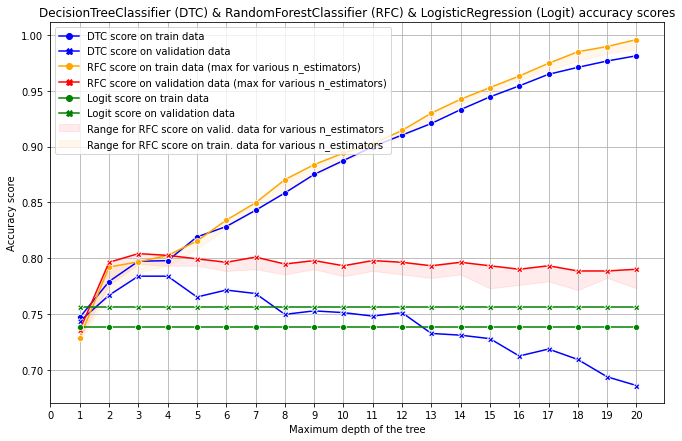

In [24]:
plt.subplots(figsize=(11, 7))

fig = sns.lineplot(
    data=accuracy_dtc.set_index("depth", drop=True).drop("seconds_fit_runs", axis=1),
    palette=["b", "b"],
    markers=True,
    markeredgecolor="w",
    dashes=False,
)
sns.lineplot(
    data=accuracy_rfc.drop(
        ["n_estimators", "seconds_fit_runs"],
        axis=1,
    )
    .groupby("depth")
    .max(),
    palette=["orange", "r"],
    markers=True,
    markeredgecolor="w",
    dashes=False,
)

sns.lineplot(
    data=pd.DataFrame(
        [[accuracy_lgr["score_on_train"].max(), accuracy_lgr["score_on_valid"].max()]]
        * len(accuracy_dtc_arr),
        columns=["score_on_train", "score_on_valid"],
        index=range(1, len(accuracy_dtc_arr) + 1),
    ),
    palette=["g", "g"],
    markers=True,
    markeredgecolor="w",
    dashes=False,
)

rfc_accuracy_grouped = (
    accuracy_rfc.groupby("depth").agg({"score_on_valid": ["min", "mean", "max"]})
    #   .unstack("Depth")
)

rfc_accuracy_grouped.columns = ["lower", "mean", "upper"]


fig.fill_between(
    rfc_accuracy_grouped.index,
    rfc_accuracy_grouped.lower,
    rfc_accuracy_grouped.upper,
    alpha=0.08,
    color="r",
    label="Range for RFC",
)


rfc_accuracy_grouped = (
    accuracy_rfc.groupby("depth").agg({"score_on_train": ["min", "mean", "max"]})
    #   .unstack("Depth")
)

rfc_accuracy_grouped.columns = ["lower", "mean", "upper"]


fig.fill_between(
    rfc_accuracy_grouped.index,
    rfc_accuracy_grouped.lower,
    rfc_accuracy_grouped.upper,
    alpha=0.08,
    color="orange",
    label="range",
)

handles, labels = fig.get_legend_handles_labels()
labels = [
    "DTC score on train data",
    "DTC score on validation data",
    "RFC score on train data (max for various n_estimators)",
    "RFC score on validation data (max for various n_estimators)",
    "Logit score on train data",
    "Logit score on validation data",
    "Range for RFC score on valid. data for various n_estimators",
    "Range for RFC score on train. data for various n_estimators",
]

fig.legend(handles=handles, labels=labels)
fig.set_title(
    "DecisionTreeClassifier (DTC) & RandomForestClassifier (RFC) & LogisticRegression (Logit) accuracy scores"
)

fig.set_ylabel("Accuracy score")
fig.set_xlabel("Maximum depth of the tree")
fig.set_xticks(range(len(accuracy_dtc) + 1))
plt.grid()
plt.show()

Для модели LogisticRegressions результаты представляют собой горизонтальную прямую максимальных значений качества для валидационной и тренировочной выборок, т.к. параметр max_depth в этой модели неприменим. Для RandomForestClassifier на графике в виде линий с точками - максимумы для каждого значения гиперпараметра max_depth среди всех рассмотренных значений гиперпараметра n_estimates. Под этими линиями закрашенные зоны - возможные отклонения от этих максимальных величин, получающиеся при других неоптимальных значениях парамтра n_estimates.

<b>Выводы: </b>
* Самые высокие значения accuracy на валидационной выборке получаются у модели RandomForestClassifier. Так как она является усовершенствованием модели DecisionTreeClassifier, то значения accuracy даже при неоптимальных выборах параметра числа деревьев, все равно при глубине деревьев 2 и более всегда превышают значения accuracy для DTC. 
* На обучающей выборке различия в качестве моделей DTC и RFC уже имеют другой характер: здесь accuracy для DTC близка к максимальным значениям для RFC, а при неоптимальном выборе числа деревьев для RFC accuracy у RFC модели может получиться и ниже. 
* LogisticRegressions на валидационной выборке показывает результаты лучше чем она же на обучающей выборке. По сравнению с остальными ее максимальные значения accuracy конкурируют с DTC и RFC моделями лишь при неоптимальных значениях их гиперпараметров (с RFC - только при max_depth = 1, c DTC - при max_depth = 1 и max_depth > 8)

## Тестирование модели

Возьмем модели с гиперпараметрам, дающими самое высокое качество предсказания (accuracy score) для валидационного датасета и проверим их на тестовой выборке:

In [25]:
models = [
    RandomForestClassifier(random_state=6_10_22, max_depth=3, n_estimators=165),
    RandomForestClassifier(random_state=6_10_22, max_depth=3, n_estimators=203),
    RandomForestClassifier(random_state=6_10_22, max_depth=3, n_estimators=326),
    DecisionTreeClassifier(random_state=6_10_22, max_depth=3),
    DecisionTreeClassifier(random_state=6_10_22, max_depth=4),
    LogisticRegression(random_state=6_10_22, solver="newton-cg", max_iter=40),
    LogisticRegression(random_state=6_10_22, solver="lbfgs", max_iter=49),
]

Опять обучим их и получим данные accuracy score на обучающей, валидационной и тестовой выборках:

In [26]:
results_for_test_split_arr = []
for model in models:
    start_time = time.time()
    model.fit(features_train, target_train)
    seconds_fit_runs = time.time() - start_time

    add_model_record(
        results_for_test_split_arr,
        model=model,
        score_on_train=accuracy_score(model.predict(features_train), target_train),
        score_on_valid=accuracy_score(model.predict(features_valid), target_valid),
        score_on_test=accuracy_score(model.predict(features_test), target_test),
        seconds_fit_runs=seconds_fit_runs,
    )

In [27]:
pd.DataFrame(results_for_test_split_arr).style.background_gradient(cmap=cm)

,model,score_on_train,score_on_valid,score_on_test,seconds_fit_runs
0,"RandomForestClassifier(max_depth=3, n_estimators=165, random_state=61022)",0.794606,0.804044,0.814930,0.242005
1,"RandomForestClassifier(max_depth=3, n_estimators=203, random_state=61022)",0.794606,0.804044,0.816485,0.290998
2,"RandomForestClassifier(max_depth=3, n_estimators=326, random_state=61022)",0.795643,0.804044,0.814930,0.452705
3,"DecisionTreeClassifier(max_depth=3, random_state=61022)",0.797199,0.783826,0.800933,0.003300
4,"DecisionTreeClassifier(max_depth=4, random_state=61022)",0.797718,0.783826,0.800933,0.003393
5,"LogisticRegression(max_iter=40, random_state=61022, solver='newton-cg')",0.738589,0.754277,0.763608,0.084820
6,"LogisticRegression(max_iter=49, random_state=61022)",0.738589,0.755832,0.766719,0.015346


<b>Выводы: </b> Лучшая модель на валидации - RandomForestClassifier показала на тестовой выборке результат accuracy ~0.817 (max_depth=3, n_estimators=203). Рассмотрев результаты остальных моделей на тестовой выборке можно увидеть, что их качество предсказания (accuracy) немного превысило результаты не только для валидационной выборки но и для обучающей. В целом видно, что выбранные значения гиперпараметров для всех моделей достаточно оптимально работают и на тестовой выборке.

## Проверка модели на адекватность

Проверим модели на адекватность (sanity check). Если выбирать значение `is_ultra` случайным образом, то есть вероятность значения `P(0) = P(1) = 0.5`. Убедимся что в таком случае accuracy score будет меньше чем у исследованных выше моделей классификации.

In [28]:
import random

sum_score = 0
for i in range(0, 1000):
    sum_score += accuracy_score(
        [random.randint(0, 1) for _ in range(0, len(target_test))], target_test
    )
print(sum_score / 1000)

0.49884292379471223


<b>Выводы: </b>Видим, что значение accuracy в случае случайного выбора is_ultra стремится к 0.5. Что говорит о том, что наши модели классификации действительно работают и результаты их предсказания  лучше случайного выбора значения (accuracy от 0.76 до 0.816 на тестовой выборке).

## Общий вывод

Исследовав модели классификации LogisticRegression, DecisionTreeClassifier и RandomForestClassifier на данных по мобильным тарифам мы обнаружили следующее:

* В датасете была обнаружена практически линейная связь между calls и minutes и для предотвращения <b>мультиколлинеарности</b> call и minutes в факторах(features) из двух оставили только столбец minutes.

* Для модели <b>LogisticRegression</b> максимальное значение accuracy по валидационной выборке `0.754277`, `0.755832` получается для алгоритмов newton-cg и lbfgs соответственно. Причем lbfgs обучается быстрее чем newton-cg примерно в 4 раза (seconds_fit_runs), а для достижения максимальной точности lbfgs требуется на 4-13 итераций (значение max_iter) больше чем для newton-cg. Кроме того, на графике видно, что если у алгоритма newton-cg значение accuracy практически постоянно растет с увеличением параметра max_iter до уровня "насыщения" , то у lbfgs наблюдатся сильные колебания в показаниях качества модели в диапазоне max_iter ~ [20-50] и потом она приходит к тому же уровню, что и newton-cg. Остальные алгоритмы получают на валидационной выборке более плохой результат для accuracy, ниже целевого 0.75.

* Для модели <b>DecisionTreeClassifier</b> максимальное значение accuracy по валидационной выборке `0.783826` получается для глубины дерева (`max_depth`), равной `3` и `4`.

* Максимальное значение accuracy модели <b>RandomForestClassifier</b> для валидационного датасета `0.804044` достигается при близком значении accuracy для тренировочного датасета `0.795643`, а далее модель при увеличении глубины деревьев уходит в "зону переобучения". В то же время много значений числа деревьев (n_estimators) в диапазонах [154..211] и [325..450] показали одинаково максимальный результат качества модели на валидационной выборке при глубине дерева = 3.

* Если проводить <b>сравнение моделей</b> между собой:
    * Самые высокие значения accuracy на валидационной выборке получаются у модели RandomForestClassifier. Так как она является усовершенствованием (ансамблем) модели DecisionTreeClassifier, то значения accuracy даже при неоптимальных выборах параметра числа деревьев, все равно при глубине деревьев 2 и более всегда превышают значения accuracy для DTC. 
    * На обучающей выборке различия в качестве моделей DTC и RFC уже имеют другой характер: здесь accuracy для DTC близка к максимальным значениям для RFC, а при неоптимальном выборе числа деревьев для RFC accuracy у RFC модели может получиться и ниже. 
    * LogisticRegressions на валидационной выборке показывает результаты лучше чем она же на обучающей выборке. По сравнению с остальными ее максимальные значения accuracy конкурируют с DTC и RFC моделями лишь при неоптимальных значениях их гиперпараметров (с RFC - только при max_depth = 1, c DTC - при max_depth = 1 и max_depth > 8)

* Рассмотрев результаты выбранных моделей <b>на тестовой выборке</b> можно увидеть, что их качество предсказания (accuracy) превысило результаты не только для валидационной выборки но и для обучающей. Лучше всех себя опять показала модель RandomForestClassifier, на втором месте - DecisionTreeClassifier, а на третьем месте совсем немногим превысив целевой показатель значения accuracy - LogisticRegression. В целом видно, что выбранные значения гиперпараметров достаточно оптимально работают и на тестовой выборке.

* При проверке модели на <b>адекватность</b>, что значение accuracy в случае случайного выбора is_ultra стремится к 0.5. Что говорит о том, что модель классификации действительно работает и результат ее предсказания лучше случайного выбора значения (accuracy ~0.817 на тестовой выборке).
